In [39]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import cumtrapz
from sympy.solvers import solve
from scipy.optimize import *
from sympy import *

### Properties and Inputs

In [40]:
#Material Properties - Composite UD Tape
aluminium = {
    'Ex': 69e03,    #MPa
    'Ey': 69e03,    #MPa
    'Gxy': 26e03,   #MPa
    'vxy': 0.29,    #[-]
    'Xt': 410,      #MPa
    'Xc': 430,      #MPa
    'Yt': 400,      #MPa
    'Yc': 430,      #MPa
    'S': 230,       #MPa
    'rho': 2.77e-06 #kg/mm^3
}
#create an array of the properties
aluminiumprop = np.array(list(aluminium.values()))

#Knockdown Factors 
KF = 0.8 * 0.8 * 0.65
aluminiumprop[4:9] = aluminiumprop[4:9] * KF
Gc = 0.7 * aluminiumprop[2]

In [41]:
#Loads
V   = 1.5e06 #N
M   = 15e09  #Nmm
Dia = 6000   #mm
R = Dia/2

In [42]:
zone = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

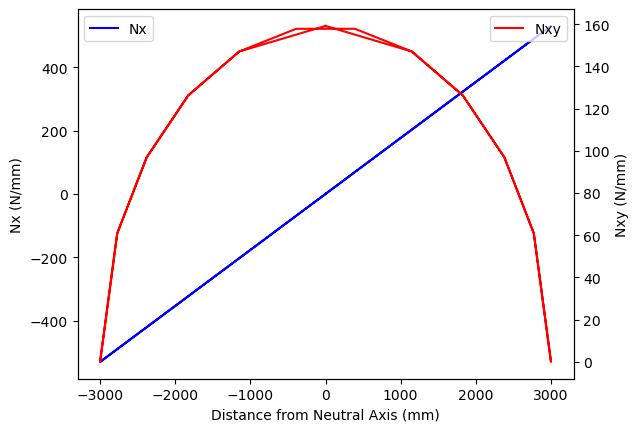

In [43]:
Nx = [] # Inplane loads in material coordinate system
Nxy = []
yloc = [] # Distance of the interval from the neutral axis
loc = [0, 22.5, 37.5, 52.5, 67.5, 90, 90, 112.5, 127.5, 142.5, 157.5, 172.5, 187.5, 202.5, 217.5, 232.5, 247.5, 270, 270, 292.5, 307.5, 322.5, 337.5, 360] #Gives 6 different thickness zones
lll = len(loc)/2
lll = int(lll)
for m in loc:
    m = m*np.pi/180
    
    # Bending stress*thickness at every interval
    y = R*np.sin(m)
    I_xx = np.pi*(R**3)
    Nz = M*y/I_xx
    Nx.append(Nz)
    
    # Shear flow at every interval
    qs = V/(np.pi*R)*(np.cos(m))
    Nxy.append(abs(qs))
    
    yloc.append(y)

# Plot Nx and Nxy with respect to yloc on a log scale. plot Nxy on a secondary axis
fig, ax1 = plt.subplots()
ax1.plot(yloc, Nx, 'b-', label='Nx')
ax1.set_xlabel('Distance from Neutral Axis (mm)')
ax1.set_ylabel('Nx (N/mm)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(yloc, Nxy, 'r-', label='Nxy')
ax2.set_ylabel('Nxy (N/mm)')
ax2.legend(loc='upper right')

plt.show()

### Classical Laminate Theory

In [44]:
def calculate_hz(lt, k):
    h = lt * k
    mid_plane = h / 2
    z = np.linspace(-mid_plane, mid_plane, k+1)
    return h, z

In [45]:
def Q_Mat(E1, E2, v12, G12): #On axis Q
    v21 = (v12*E2)/E1
    Qv = 1 - (v12*v21)
    Q11 = E1/Qv
    Q22 = E2/Qv
    Q12 = (v12*E2)/Qv
    Q33 = G12
    QM = np.array([[Q11, Q12, 0], [Q12, Q22, 0], [0, 0, Q33]])
    return QM

In [46]:
def Q_matrix(QM, theta):
    m = np.cos(np.radians(theta))
    n = np.sin(np.radians(theta))
    
    # Calculate individual components of Q matrix
    Qxx = QM[0, 0]*m**4 + QM[1, 1]*n**4 + 2*m**2*n**2*QM[0, 1] + 4*m**2*n**2*QM[2, 2]
    Qxy = QM[0, 0]*m**2*n**2 + QM[1, 1]*m**2*n**2 + QM[0, 1]*(m**4 + n**4) - 4*QM[2, 2]*m**2*n**2
    Qxs = QM[0, 0]*m**3*n - QM[1, 1]*m*n**3 + QM[0, 1]*(m*n**3 - m**3*n) + 2*(m*n**3 - m**3*n)*QM[2, 2]
    Qyy = QM[0, 0]*n**4 + QM[1, 1]*m**4 + 2*m**2*n**2*QM[0, 1] + 4*m**2*n**2*QM[2, 2]
    Qys = QM[0, 0]*m*n**3 - QM[1, 1]*m**3*n + QM[0, 1]*(m**3*n - m*n**3) + 2*(m**3*n - m*n**3)*QM[2, 2]
    Qss = QM[0, 0]*m**2*n**2 + QM[1, 1]*m**2*n**2 - 2*QM[0, 1]*m**2*n**2 + (m**2 - n**2)**2*QM[2, 2]
    
    # Assemble Q matrix
    Qxys = np.array([[Qxx, Qxy, Qxs], [Qxy, Qyy, Qys], [Qxs, Qys, Qss]])
    return Qxys

In [47]:
def ABD(Qxys, z, k):
        
    # Initialize A, B, and D matrices
    A = np.zeros((3, 3))
    B = np.zeros((3, 3))
    D = np.zeros((3, 3))
    
    # Compute A, B, and D matrices
    for i in range(k):
        # A matrix
        A += Qxys[:,:,i]*(z[i+1] - z[i])
        
        # B matrix
        B += (1/2)*(Qxys[:,:,i]*(z[i+1]**2 - z[i]**2))
        
        # D matrix
        D += (1/3)*(Qxys[:,:,i]*(z[i+1]**3 - z[i]**3))
    
    # Assemble ABD matrix
    ABD_matrix = np.block([[A, B], [B, D]])
    return ABD_matrix

### Compute Strain and Stress

In [48]:
def Strain(NM, ABD_matrix):
    # Calculate strains
    inverse_ABD = np.linalg.inv(ABD_matrix)
    strains = np.dot(inverse_ABD, NM)
    return strains

In [49]:
def L_strain(theta, strains, zt):
    strain = strains[:3]
    curv = strains[3:]
    netstrain = strain + zt*curv
    m = np.cos(np.radians(theta))
    n = np.sin(np.radians(theta))
    T = np.array([[m**2, n**2, m*n], [n**2, m**2, -m*n], [-2*m*n, 2*m*n, m**2-n**2]])
    laminastrain = np.dot(T, netstrain)
    return laminastrain

In [50]:
def L_stress(laminastrain, QM):
    laminastress = np.dot(QM, laminastrain)
    return laminastress

### Von-Mises Criteria

In [51]:
def vonMises(aluminiumprop, laminastress):
    # Calculate von Mises stress for isotropic materials
    sigma_yield1 = min(aluminiumprop[4], aluminiumprop[5])
    sigma_yield2 = min(aluminiumprop[6], aluminiumprop[7])
    sigma_yield3 = min(sigma_yield1, sigma_yield2)
    sigma_yield4 = aluminiumprop[8]
    sigma_x, sigma_y, tau_xy = laminastress
    a = sigma_x**2/sigma_yield1**2
    b = sigma_y**2/sigma_yield2**2
    c = sigma_x*sigma_y/sigma_yield3**2
    d = 3*tau_xy**2/sigma_yield4**2
    return a + b - c + d

In [52]:
def miniNx(m, D_11, D_12, D_22, D_66, AR, a):
    Nx_01 = (np.pi/a)**2 * (D_11*m**2 + 2*(D_12+2*D_66)*AR**2 + D_22 * AR**4/m**2)
    return Nx_01

In [53]:
def bucklingNx(ABD_matrix, zone, h, Gc):
    D = ABD_matrix[3:, 3:]
    b = 3000*zone*np.pi/180
    a = 600
    AR = a/b
    D_11 = D[0,0]
    D_12 = D[0,1]
    D_22 = D[1,1]
    D_66 = D[2,2]
    k1 = 5/6
    initial_guess = 1
    bounds = Bounds(1, np.inf)
    result = minimize(miniNx, initial_guess, args=(D_11, D_12, D_22, D_66, AR, a), bounds=bounds)
    m = int(np.round(result.x[0]))
    Nx_01 = (np.pi/a)**2 * (D_11*m**2 + 2*(D_12+2*D_66)*AR**2 + D_22 * AR**4/m**2)
    Nx_02 = Nx_01/(1 + (k1*Nx_01/(h*Gc)))
    return min(Nx_01, Nx_02)

In [54]:
def bucklingNxy(ABD_matrix, zone, h, Gc):
    D = ABD_matrix[3:, 3:]
    b = 3000*zone*np.pi/180
    a = 600
    AR = a/b
    D_11 = D[0,0]
    D_12 = D[0,1]
    D_22 = D[1,1]
    D_66 = D[2,2]
    Nxy_01 = 0.7 * ((9 * np.pi**4 * b) / (32 * a**3)) * (D_11 + (2 * (D_12 + 2 * D_66) * (AR**2)) + (D_22 * (AR**4)))
    Nxy_02 = Nxy_01/(1 + (Nxy_01/(h*Gc)))
    return min(Nxy_01, Nxy_02)

In [55]:
def bucklingMS(Nx, Nxy, N_x_array, N_xy_array, Buckling):
    RF = []
    for i in range(len(Buckling)):
        A = (-1)*(Nx[i+11] / N_x_array[i])
        B = (Nxy[i+11] / N_xy_array[i])**2
        x = Symbol('x')
        roots = solve(B*x**2 + A*x - 1, real=True)
        RF.append(max(roots))

    #Find minimum of RF and round to 2 decimal places
    minRF = min(RF)
    minRF = round(minRF, 2)
    return minRF, (minRF-1)

### Results

In [56]:
lt = 10 #mm
while True:
    RFabd = []
    N_x_list = []
    N_xy_list = []
    count = 0  
    theta = [0]
    for idx in range(len(loc)):
        k = len(theta)
        NM = np.array([[Nx[idx]], [0.], [Nxy[idx]], [0.], [0.], [0.]])
        h, z = calculate_hz(lt, k)
        QM = Q_Mat(aluminiumprop[0], aluminiumprop[1], aluminiumprop[3], aluminiumprop[2])
        Qxys = np.zeros((3, 3, k))
        for i in range(k):
            Qxys[:, :, i] = Q_matrix(QM, theta[i])
        
        ABD_matrix = ABD(Qxys, z, k)

        strains = Strain(NM, ABD_matrix)
        zt = z[:-1]+lt/2
        strain = strains[:3]
        curv = strains[3:]
        netstrain = strain + zt*curv

        laminastrain = np.zeros((3, 1, k))
        laminastress = np.zeros((3, 1, k))
        VM = np.zeros((1, 1, k))
        for i in range(k):
            laminastrain[:, :, i] = L_strain(theta[i], strains, zt[i])
            laminastress[:, :, i] = L_stress(laminastrain[:, :, i], QM)
            
            VM[:, :, i] = vonMises(aluminiumprop, laminastress)

        if max(VM) >= 1:
            count = 1
            #print('Failure Occurs')  

        RFabd.append(1/max(VM))      

        if idx>=lll:
            N_x_list.append(bucklingNx(ABD_matrix, zone[idx], h, Gc))
            N_xy_list.append(bucklingNxy(ABD_matrix, zone[idx], h, Gc))
            #print('-----------------------')

    N_x_array = np.array(N_x_list)
    #print(N_x_array)
    N_xy_array = np.array(N_xy_list)
    #print(N_xy_array)
    Buckling = ((-1)*((Nx[lll:] / N_x_array))) + ((Nxy[lll:] / N_xy_array)**2)
    #print(Buckling)
    minRF, bMS= bucklingMS(Nx, Nxy, N_x_array, N_xy_array, Buckling)
    if bMS<=1 or count>=1:
        lt = lt + 0.5
        #print(bMS, count, lt)
    else:
        break

print('Final Thickness', h, 'mm')
print('Minimum RF for combined Nx-Nxy Loading:', np.round(min(RFabd), 2))
print('Minimum Margin of Safety for combined Nx-Nxy Loading:', np.round(min(RFabd)-1, 2))
print('Location of Minimum Margin of Safety for combined Nx-Nxy Loading:', np.argmin(RFabd)+1)
print('Maximum Buckling Factor:', np.round(max(Buckling),2))
print('Minimum RF for Buckling:', minRF)
print('Minimum Margin of Safety for Buckling:', round(bMS, 2))

Final Thickness 14.0 mm
Minimum RF for combined Nx-Nxy Loading: [[20.26]]
Minimum Margin of Safety for combined Nx-Nxy Loading: [[19.26]]
Location of Minimum Margin of Safety for combined Nx-Nxy Loading: 6
Maximum Buckling Factor: 0.45
Minimum RF for Buckling: 2.20
Minimum Margin of Safety for Buckling: 1.20


In [57]:
#Area of a ring of thickness t
Area = np.pi * (R**2 - ((R - h)**2)) * 15 / 360
Mass = len(zone) * Area * aluminiumprop[9]
print('Mass:', np.round(np.sum(Mass)*1000, 2), 'kg/m')

Mass: 729.28 kg/m


In [62]:
h

14.0